# Hydrological Modelling

In [31]:
#import modules (basic)
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns


#ML packages
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import catboost as cb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

colors = sns.color_palette("colorblind")
colors2 = sns.color_palette("Set2")

In [32]:
#Where to split?
split_date="2011-01-01"



Data="../AAC2312/01_data/PTQ.txt"

#Lag settings:
lag_true = True
lags = [i for i in range(1, 21)]

#Load Dataset
data_csv= pd.read_table(Data)
data_csv["Date"]=pd.to_datetime(data_csv['Date'], format="%Y%m%d")

#split into test and trainset
row = data_csv.loc[data_csv['Date'] == pd.Timestamp(split_date)]
train_set_raw=data_csv[:row.index[0]]
test_set_raw=data_csv[row.index[0]:]

print(f"Train set: {len(train_set_raw)} observations, {round((len(train_set_raw)/len(data_csv))*100)}% of the whole Dataset")
print(f"Test set: {len(test_set_raw)} observations, {round((len(test_set_raw)/len(data_csv))*100)}% of the whole Dataset")
train_set_raw.head(2)


Train set: 11323 observations, 78% of the whole Dataset
Test set: 3103 observations, 22% of the whole Dataset


,Date,P,T,Q
0,1980-01-01,0.193,-0.131,1.7626
1,1980-01-02,1.823,-1.666,1.4692


[]

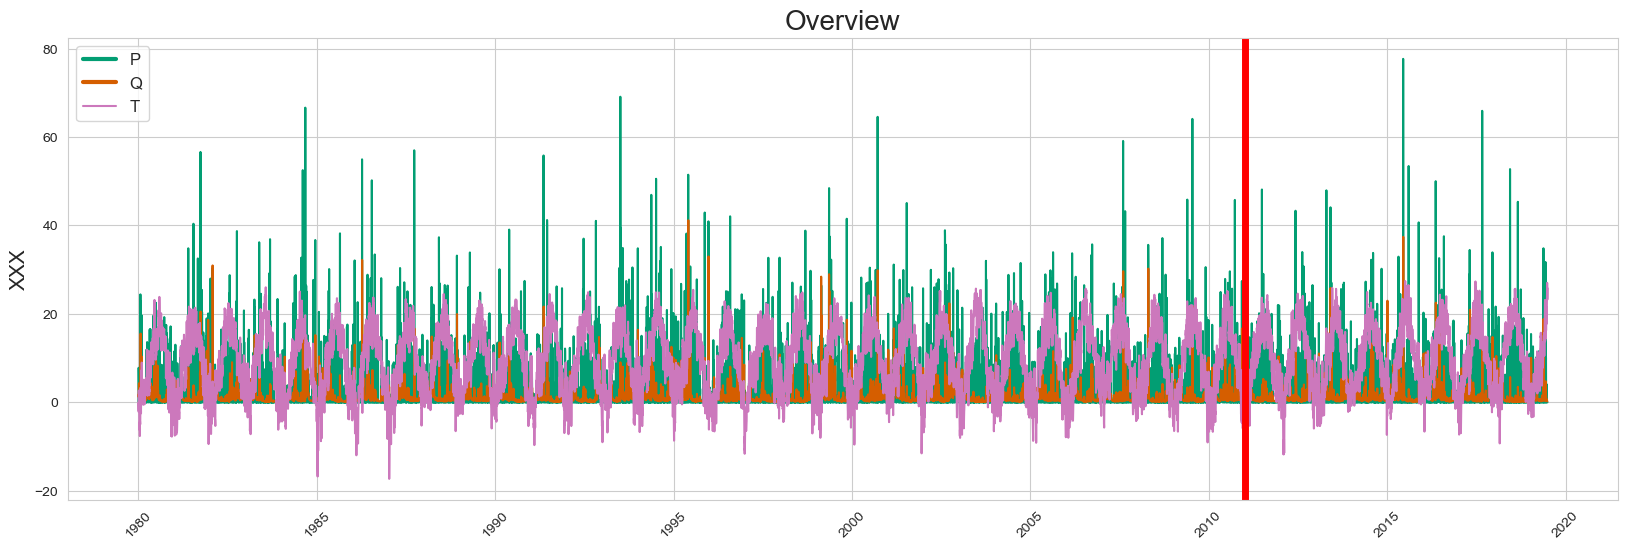

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(data_csv["Date"],data_csv["P"],label="P",color=colors[2])
plt.plot(data_csv["Date"],data_csv["Q"],label="Q",color=colors[3])
plt.plot(data_csv["Date"],data_csv["T"],label="T",color=colors[4])

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
#plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
#plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),30,120,0,head_width=2, head_length=15, fc='red', ec='red',linewidth=5)
#plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 27.5, "Test data", fontsize=25,color="red")
#plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),30,-150,0,head_width=2, head_length=15, fc='blue', ec='blue',linewidth=5)
#plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 27.5, "Train data", fontsize=25,color="blue")
plt.xticks(rotation=45)

#Other things
plt.title("Overview", fontdict={'fontsize': 20})
plt.ylabel("XXX", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
plt.plot()


# What is Gradient Boosting Regression? (Theory)


In [34]:
#CODE:
def apply_table_styles(df):
    return df.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('background-color', 'lightgray')]
            },
            {
                'selector': 'tbody tr:nth-child(even)',
                'props': [('background-color', "lightblue")]
            }
        ]
    )


comparison_dict = {
    'Algorithm': ['Random Forest', 'Gradient Boosting Regression'],
    'Training approach': ['Independent and parallel', 'Sequential and residuals'],
    'Bias-variance tradeoff': ['Higher bias, lower variance', 'Lower bias, higher variance'],
    'Speed': ['Faster for large datasets', 'Slower for large datasets'],
    'Hyperparameters': ['Number of trees, maximum depth', 'Learning rate, number of trees'],
    'Interpretability': ['Lower', 'Higher'],
    'Handling missing values': ['Able to handle missing values', 'Not able to handle missing values'],
    'Robustness to outliers': ['More robust', 'Less robust'],
    'Model performance': ['Stable performance', 'Tendency to overfit']
}

# Convert the dictionary to a pandas DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict).T.rename_axis('Algorithm', axis=1).drop(index="Algorithm")
comparison_df.columns = ['Random Forest', 'Gradient Boosting Regression']

# Create a simple dataset
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel()


# Create Gradient Boosting Regression model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train model on data
gbr.fit(X, y)
comparison_df

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


### What is this algorithm (simple explanation):

The GBR works by combining many decision trees. Each tree tries to fix the mistakes made by the previous trees. The trees are added together, creating an ensemble that makes a prediction.

The hyperparameters of GBR include the number of trees in the ensemble (n_estimators), the learning rate (learning_rate) that controls the contribution of each tree to the ensemble, and the maximum depth of each tree (max_depth), among others.

-> These hyperparameters need to be tuned carefully to obtain the best performance from the model. So we will use the CrossValidationCV module, which is quite good.

An decision tree is visualized below:


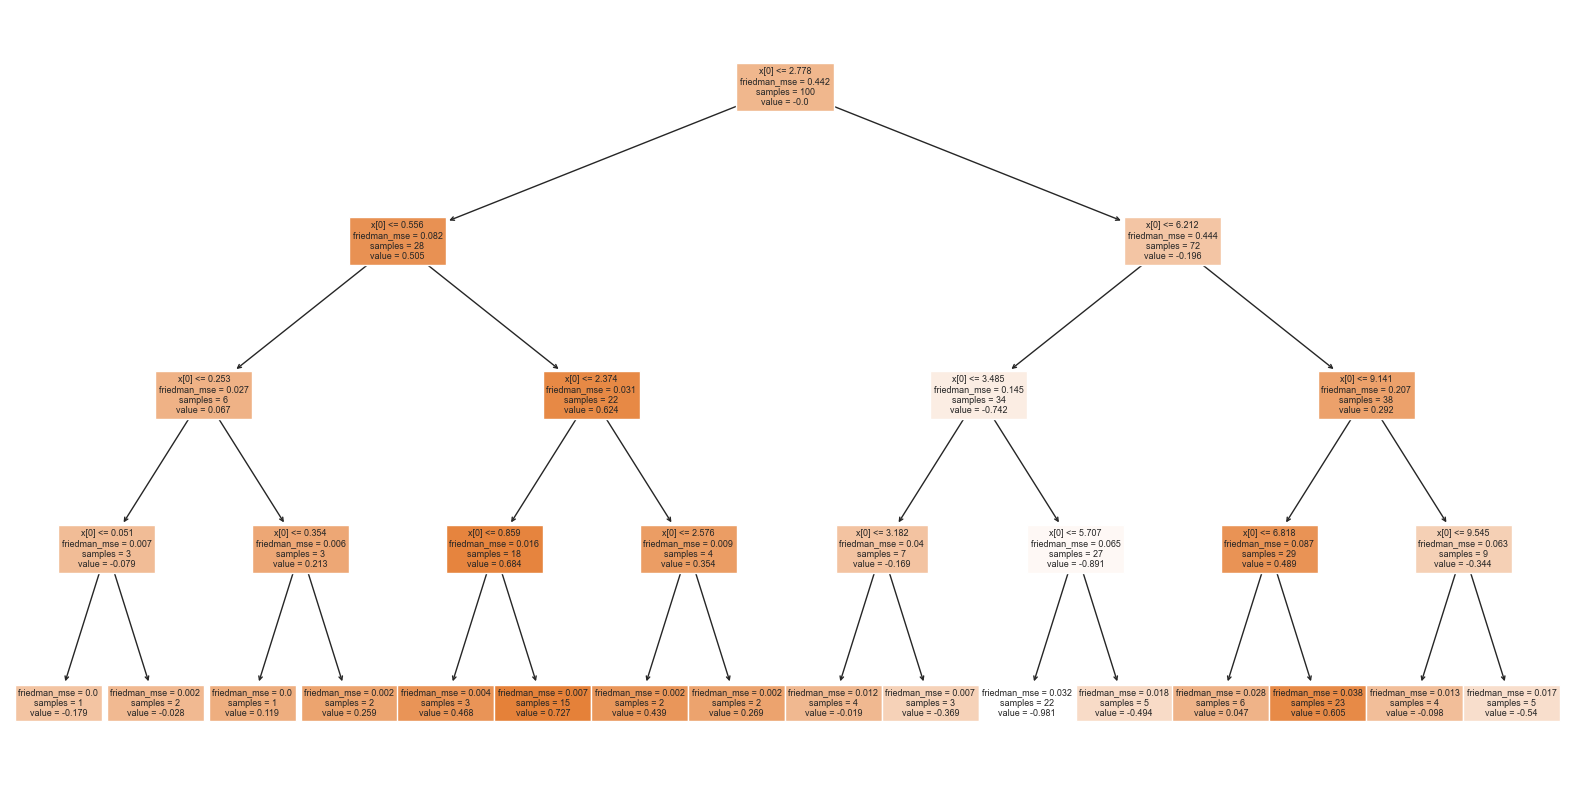

In [35]:
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], filled=True)
plt.show()

# Coding (Random Forest Regression)

without time lag it is very shit. lets try with time_lag

In [36]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()
if True:
    for i in lags:
        string_p="P"+str(i)
        string_t="T"+str(i)

        test_set[string_p]= test_set['P'].shift(i)
        train_set[string_p]= train_set['P'].shift(i)

        test_set[string_t]= test_set['T'].shift(i)
        train_set[string_t]= train_set['T'].shift(i)

    test_set=test_set.dropna()
    train_set=train_set.dropna()

test_set

,Date,P,T,Q,P1,T1,P2,T2,P3,T3,...,P16,T16,P17,T17,P18,T18,P19,T19,P20,T20
11343,2011-01-21,0.000,-2.057,1.5986,2.086,-1.028,7.059,1.898,0.065,3.313,...,0.056,-2.232,0.000,-4.127,0.000,-3.804,0.576,-1.017,0.058,0.533
11344,2011-01-22,0.000,-3.621,1.3726,0.000,-2.057,2.086,-1.028,7.059,1.898,...,4.849,2.327,0.056,-2.232,0.000,-4.127,0.000,-3.804,0.576,-1.017
11345,2011-01-23,0.000,-5.921,1.1866,0.000,-3.621,0.000,-2.057,2.086,-1.028,...,1.257,5.710,4.849,2.327,0.056,-2.232,0.000,-4.127,0.000,-3.804
11346,2011-01-24,0.108,-4.132,1.0390,0.000,-5.921,0.000,-3.621,0.000,-2.057,...,0.910,5.643,1.257,5.710,4.849,2.327,0.056,-2.232,0.000,-4.127
11347,2011-01-25,0.301,0.018,0.9861,0.108,-4.132,0.000,-5.921,0.000,-3.621,...,6.924,5.623,0.910,5.643,1.257,5.710,4.849,2.327,0.056,-2.232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14421,2019-06-26,0.000,25.521,0.2989,0.000,23.791,0.000,22.283,0.000,19.633,...,31.742,14.377,0.023,14.411,0.000,16.010,0.000,16.394,0.000,13.829
14422,2019-06-27,0.000,27.024,0.2989,0.000,25.521,0.000,23.791,0.000,22.283,...,20.871,14.617,31.742,14.377,0.023,14.411,0.000,16.010,0.000,16.394
14423,2019-06-28,0.000,23.707,0.2734,0.000,27.024,0.000,25.521,0.000,23.791,...,5.128,14.571,20.871,14.617,31.742,14.377,0.023,14.411,0.000,16.010
14424,2019-06-29,0.000,23.242,0.2570,0.000,23.707,0.000,27.024,0.000,25.521,...,0.000,17.047,5.128,14.571,20.871,14.617,31.742,14.377,0.023,14.411


In [ ]:
#Grid search is quite useful here:
#define the parameters to choose from
start_time = datetime.now()

param_grid = {
    "criterion": ["squared_error"],
    "max_depth": [9,12],
    #"min_samples_split": [2]
}
#define the scorer
#scorer = make_scorer(r2_score)
scorer = make_scorer(mean_absolute_error)

#initialize the model:
rfr = RandomForestRegressor()

#make the GridSearch:

grid_search1 = HalvingGridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=5, #
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=20
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
grid_search1.fit(train_set.drop(columns=["Q","Date"]),train_set["Q"])


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)


end_time = datetime.now()    # Get the time after the function execution
execution_time1 = end_time - start_time

test_set["Q_predicted"]= grid_search1.predict(test_set.drop(columns=["Q","Date"]))


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

mse_1=mean_squared_error(test_set["Q_predicted"],test_set["Q"])
r2_1=r2_score(test_set["Q"],test_set["Q_predicted"])
n = len(test_set["Q"])  # number of observations
p = 2  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_1) * (n - 1) / (n - p - 1)

print("Best Score (mse):",mse_1)
print("Best Score (r2):",r2_1)
print("n",n)
print("Best Score (r2_adjusted):",r2_adjusted)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 10
max_resources_: 20
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 10
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(data_csv["Date"],data_csv["Q"],label="Q", color=colors[0],alpha=1,linewidth =2)
plt.plot(test_set["Date"],test_set["Q_predicted"],label="Q_predicted", color=colors[1],alpha=0.7,linewidth =2)

#Other things
plt.title("Overview", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2015-07-31"))
plt.ylabel("XXX")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3